In [5]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import QFTGate, grover_operator, MCMTGate, ZGate, HGate
from qiskit import QuantumCircuit
from math import floor, pi
import pandas as pd
from qiskit_aer import AerSimulator
import qiskit
from qiskit.visualization import plot_histogram
from scipy.stats import linregress
from lib.lib import oracle
from plots import QC, QSubsetSum

%matplotlib inline

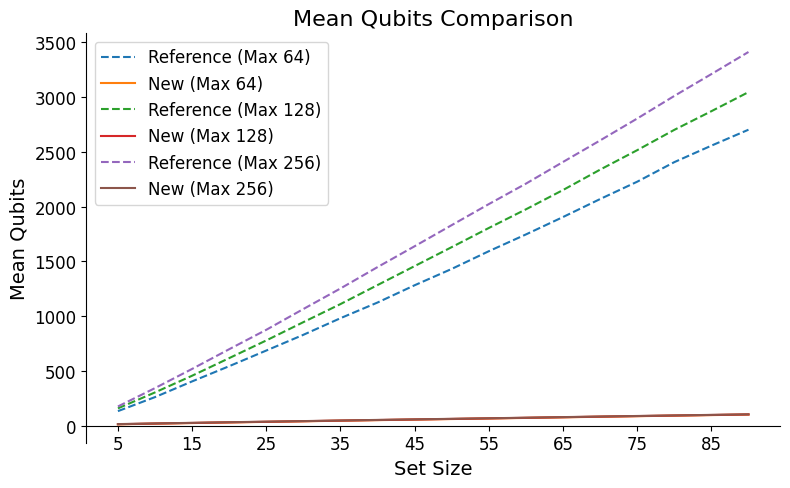

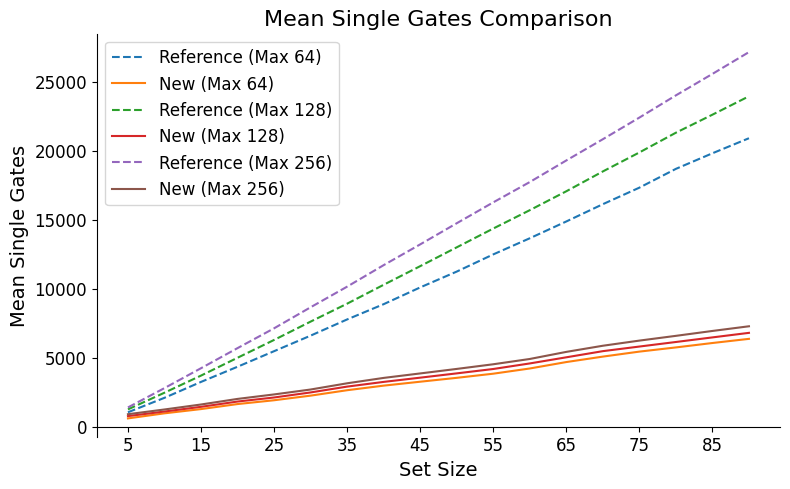

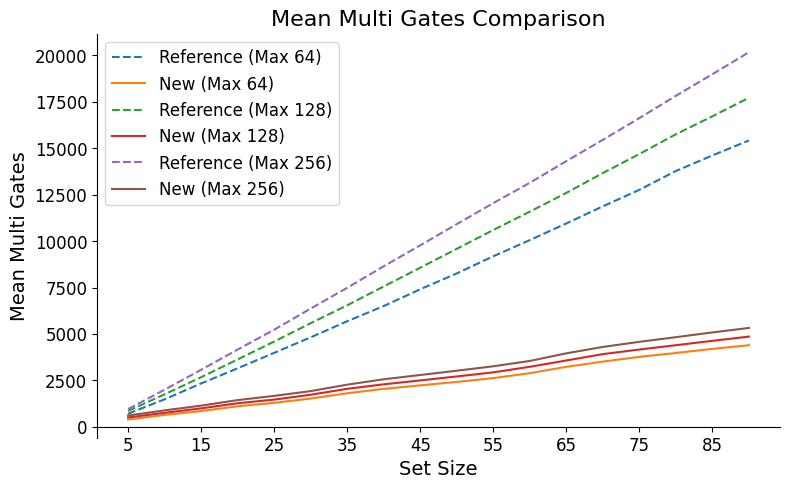

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

max_values = [64, 128, 256]
set_sizes = np.arange(5, 95, 5)
ticks = np.arange(5,95,10)

# Metrics to plot
metrics = [
    ('qubits', 'Mean Qubits'),
    ('singleGates', 'Mean Single Gates'),
    ('multiGates', 'Mean Multi Gates'),
]

# Collect results
results = {
    key: {
        val: {'reference': [], 'new': []}
        for val in max_values
    }
    for key, _ in metrics
}

for val in max_values:
    for size in set_sizes:
        data_reference = pd.read_csv(f"./tests/{size}vals{val}max_old.csv")
        data_new = pd.read_csv(f"./tests/{size}vals{val}max_new.csv")
        for key, _ in metrics:
            results[key][val]['reference'].append(data_reference[key].mean())
            results[key][val]['new'].append(data_new[key].mean())

# Plotting + linear regression
slopes_data = []

# Plotting + linear regression
for key, title in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))

    for val in max_values:
        # Reference
        y_ref = results[key][val]['reference']
        slope_ref, intercept_ref, r_value, p_value, std_err = linregress(set_sizes, y_ref)
        slopes_data.append({
            "Metric": title,
            "Max Value": val,
            "Version": "Reference",
            "Slope": slope_ref
        })
        ax.plot(set_sizes, y_ref, label=f"Reference (Max {val})", linestyle='--')

        # New
        y_new = results[key][val]['new']
        slope_new, intercept_new, r_value, p_value, std_err = linregress(set_sizes, y_new)
        slopes_data.append({
            "Metric": title,
            "Max Value": val,
            "Version": "New",
            "Slope": slope_new
        })
        ax.plot(set_sizes, y_new, label=f"New (Max {val})", linestyle='-')

    ax.set_xlabel('Set Size', fontsize=14)
    ax.set_ylabel(title, fontsize=14)
    ax.set_title(f"{title} Comparison", fontsize=16)

    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticks(ticks)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')

    plt.tight_layout()
    fig.savefig(f"{key}_combined.png")

# Create slopes DataFrame and display
slopes_df = pd.DataFrame(slopes_data)
slopes_df.to_html("slopes.html")

In [10]:
# Collect last values (final mean at largest set size)
last_values_data = []

for key, title in metrics:
    for val in max_values:
        # Reference
        y_ref = results[key][val]['reference']
        last_values_data.append({
            "Metric": title,
            "Max Value": val,
            "Version": "Reference",
            "Final Mean (Set Size 90)": y_ref[-1]
        })

        # New
        y_new = results[key][val]['new']
        last_values_data.append({
            "Metric": title,
            "Max Value": val,
            "Version": "New",
            "Final Mean (Set Size 90)": y_new[-1]
        })

# Create DataFrame and display
last_values_df = pd.DataFrame(last_values_data)
last_values_df.to_html("last_values.html")


In [4]:
instances = [
    [[1, 2, 4, 5], 5, 2],
    [[1, 2, 4, 5], 8, 2],
    [[1, 2, 4, 5], 18, 1],
    [[3, 5, 8], 8, 1],
    [[3, 5, 8], 11, 2],
    [[3, 5, 8], 12, 1],
    [[1, 2, 5, 7], 7, 2],
    [[1, 2, 5, 7], 15, 1],
    [[1, 2, 5, 7], 4, 1],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 6, 8],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 1, 16],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 58, 1],
    [[1, 1, 1, 2, 7, 9], 9, 2],
    [[1, 1, 1, 2, 7, 9], 5, 4],
    [[1, 1, 1, 2, 7, 9], 6, 1],
    [[128,16,3], 19, 1],
    [[128,16,3], 131, 1],
    [[128,16,3], 129, 1]
]

df_old = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])
df_new_no_uncompute = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])
df_new_uncompute = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])

for serial, instance in enumerate(instances):
    orcl_new_uncompute = oracle(instance[0], instance[1], old=True, uncompute=True)
    orcl_new_no_uncompute = oracle(instance[0], instance[1], old=True, uncompute=False)
    
    qubits_new_uncompute = orcl_new_uncompute.num_qubits
    qubits_new_no_uncompute = orcl_new_no_uncompute.num_qubits
    
    gates_new_uncompute = qiskit.transpile(orcl_new_uncompute, basis_gates=["h", "cx", "p"]).count_ops()
    gates_new_no_uncompute = qiskit.transpile(orcl_new_no_uncompute, basis_gates=["h", "cx", "p"]).count_ops()

    depth_new_no_uncompute = qiskit.transpile(orcl_new_no_uncompute, basis_gates=["h", "cx", "p"]).depth()
    depth_new_uncompute = qiskit.transpile(orcl_new_uncompute, basis_gates=["h", "cx", "p"]).depth()
    
    single_gates_new_no_uncompute = 0
    multi_gates_new_no_uncompute = 0
    for key,val in zip(gates_new_no_uncompute.keys(), gates_new_no_uncompute.values()):
        if key == "cx":
            multi_gates_new_no_uncompute += val
        else:
            single_gates_new_no_uncompute += val

    single_gates_new_uncompute = 0
    multi_gates_new_uncompute = 0

    for key,val in zip(gates_new_uncompute.keys(), gates_new_uncompute.values()):
        if key == "cx":
            multi_gates_new_uncompute += val
        else:
            single_gates_new_uncompute += val

    orcl_old = QSubsetSum(instance[0], instance[1])
    ans = orcl_old.run(True, True, True, True) #varArith with sorted values and partial sum

    depth_old = qiskit.transpile(orcl_old.qc.qcx, basis_gates=["h", "cx", "p"]).depth()
    df_old.loc[serial] = [serial+1] + list(ans) + [depth_old]
    
    df_new_uncompute.loc[serial] = [serial+1, orcl_new_uncompute.num_qubits, single_gates_new_uncompute, multi_gates_new_uncompute, depth_new_uncompute]
    df_new_no_uncompute.loc[serial] = [serial+1, orcl_new_uncompute.num_qubits, single_gates_new_no_uncompute, multi_gates_new_no_uncompute, depth_new_no_uncompute]
display(df_old, df_new_no_uncompute, df_new_uncompute)
df_old.to_csv('old.csv', index=False) 
df_new_no_uncompute.to_csv("new_no.csv", index=False)
df_new_uncompute.to_csv("new_with.csv", index=False)

,Serial,qubits,single_gates,multi_gates,depth
0,1,54,385,243,358
1,2,54,382,243,358
2,3,54,382,243,358
3,4,56,401,251,370
4,5,56,407,251,370
5,6,56,404,251,370
6,7,56,405,251,371
7,8,56,408,251,371
8,9,56,399,251,371
9,10,167,1292,903,1303


,Serial,qubits,single_gates,multi_gates,depth
0,1,8,140,63,98
1,2,8,134,63,97
2,3,9,190,101,147
3,4,8,195,99,159
4,5,8,201,99,159
5,6,8,198,99,159
6,7,8,179,75,126
7,8,8,179,75,126
8,9,8,173,75,126
9,10,16,456,239,348


,Serial,qubits,single_gates,multi_gates,depth
0,1,8,278,112,168
1,2,8,266,112,164
2,3,9,358,176,239
3,4,8,369,172,260
4,5,8,381,172,260
5,6,8,375,172,260
6,7,8,356,136,228
7,8,8,356,136,228
8,9,8,344,136,228
9,10,16,893,444,619


In [7]:
cols = ["qubits", "single_gates", "multi_gates", "depth"]
comp = df_old.copy()
comp[cols] = df_old[cols] / df_new_no_uncompute[cols]
comp[cols] = comp[cols].map(lambda x: f"{x:.2f}")
comp.to_csv("comp.csv", index=False)

In [40]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import DraperQFTAdder
qc = QuantumCircuit()
n = 3
a = QuantumRegister(n, "a")
b = QuantumRegister(n, "b")

qc.add_register(a, b)
qc.append(DraperQFTAdder(n), list(range(2*n)))

qc.decompose().decompose().draw()

a_0: ─────────■──────■────────■───────────────────────────────────────
              │      │        │                                       
a_1: ─────────┼──────┼────────┼────────■──────■───────────────────────
              │      │        │        │      │                       
a_2: ─────────┼──────┼────────┼────────┼──────┼────────■──────────────
     ┌──────┐ │P(π)  │        │        │      │        │     ┌───────┐
b_0: ┤0     ├─■──────┼────────┼────────┼──────┼────────┼─────┤0      ├
     │      │        │P(π/2)  │        │P(π)  │        │     │       │
b_1: ┤1 QFT ├────────■────────┼────────■──────┼────────┼─────┤1 IQFT ├
     │      │                 │P(π/4)         │P(π/2)  │P(π) │       │
b_2: ┤2     ├─────────────────■───────────────■────────■─────┤2      ├
     └──────┘                                                └───────┘

In [38]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import DraperQFTAdder
qc = QuantumCircuit()
a = QuantumRegister(n, "a")
b = QuantumRegister(n, "b")
qc.add_register(a, b)
qc.x(a[1])

qc.x(b[2])


qc.compose(DraperQFTAdder(n).decompose(), list(range(2*n)), inplace=True)

qc.draw()

a_0: ──────────────■──────■────────■───────────────────────────────────────
     ┌───┐         │      │        │                                       
a_1: ┤ X ├─────────┼──────┼────────┼────────■──────■───────────────────────
     └───┘         │      │        │        │      │                       
a_2: ──────────────┼──────┼────────┼────────┼──────┼────────■──────────────
          ┌──────┐ │P(π)  │        │        │      │        │     ┌───────┐
b_0: ─────┤0     ├─■──────┼────────┼────────┼──────┼────────┼─────┤0      ├
          │      │        │P(π/2)  │        │P(π)  │        │     │       │
b_1: ─────┤1 QFT ├────────■────────┼────────■──────┼────────┼─────┤1 IQFT ├
     ┌───┐│      │                 │P(π/4)         │P(π/2)  │P(π) │       │
b_2: ┤ X ├┤2     ├─────────────────■───────────────■────────■─────┤2      ├
     └───┘└──────┘                                                └───────┘

In [37]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import DraperQFTAdder, QFTGate
from math import pi

qc = QuantumCircuit()
b = QuantumRegister(n, "b")
qc.add_register(b)

qc.x(b[2])
qc.compose(QFTGate(n), list(range(n)), inplace=True)
qc.p(-pi, b[1])
qc.p(-pi/2, b[2])
qc.p(-pi, b[2])
qc.compose(QFTGate(n).inverse(), list(range(n)), inplace=True)

with open("./U_f_s_i.tex", "w+") as f:
    f.write(qc.draw("latex_source"))

$f_{s_i}: \mathbb{Z} \to \mathbb{Z}, x \mapsto x - s_i$

$U_{f_{s_i}}\ket{n} \mapsto \ket{n - s_i}$

In [5]:
from lib.lib import grovers, simulate

In [15]:
simulate([128, 16, 3], 131, 1).iloc[0] / 4096

np.float64(0.947509765625)

In [1]:
from lib.lib import oracle, simulate

In [2]:
oracle([1,2], 3).draw(fold=-1)

┌────────┐                                            ┌───────┐                         
   index_0: ─────────────┤0       ├────────────────────────────────────────────┤0      ├─────────────────────────
                         │        │┌────────┐                                  │       │┌───────┐                
   index_1: ─────────────┤        ├┤0       ├──────────────────────────────────┤       ├┤0      ├────────────────
            ┌───┐┌──────┐│  R(-1) ││        │┌─────────┐┌───┐ 1-Z ┌───┐┌──────┐│  R(1) ││       │┌─────────┐┌───┐
  target_0: ┤ X ├┤0     ├┤1       ├┤1 R(-2) ├┤0        ├┤ X ├──■──┤ X ├┤0     ├┤1      ├┤1 R(2) ├┤0        ├┤ X ├
            ├───┤│  Qft ││        ││        ││  qft_dg │├───┤  │  ├───┤│  Qft ││       ││       ││  qft_dg │├───┤
  target_1: ┤ X ├┤1     ├┤2       ├┤2       ├┤1        ├┤ X ├──■──┤ X ├┤1     ├┤2      ├┤2      ├┤1        ├┤ X ├
            └───┘└──────┘└────────┘└────────┘└─────────┘└───┘     └───┘└──────┘└───────┘└───────┘└─────────┘└───┘
target_M: 2/═════════════════════════════════════════════════════════════════════════════════════════════════════

In [5]:
simulate([1,2,1],3,2)

011    2070
110    2026
dtype: int64